In [29]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random



In [30]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Definir dataset personalizado
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_NOK=False):
        """
        root_dir: Directorio raíz donde están las carpetas kos01, kos02, ...
        transform: Transformaciones a aplicar a las imágenes.
        augment_NOK: Si es True, aplica data augmentation a imágenes NOK.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augment_NOK = augment_NOK
        self.data = []
        self._load_data()
    
    def _load_data(self):
        # Iterar por las carpetas kos01 a kos50
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            
            # Leer imágenes y máscaras
            images = sorted(glob.glob(os.path.join(folder_path, "Part*.jpg")))
            masks = sorted(glob.glob(os.path.join(folder_path, "Part*_label.bmp")))
            
            for img_path, mask_path in zip(images, masks):
                # Cargar máscara y verificar si tiene defectos
                mask = Image.open(mask_path).convert("L")
                mask_tensor = transforms.ToTensor()(mask)  # Convertir máscara a tensor
                
                # OK si todos los valores son 0 (negro), NOK si hay valores > 0
                label = 1 if mask_tensor.max() > 0 else 0
                
                # Guardar la ruta de la imagen y su etiqueta
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
        
        # Data augmentation solo para imágenes NOK si está habilitado
        if self.augment_NOK and label == 1:
            augmentations = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.RandomHorizontalFlip(),
            ])
            image2 = augmentations(image)
        
        return image, label


# Configuración de transformaciones
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar imágenes para entrenamiento
    transforms.ToTensor(),          # Convertir a tensores
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizar
])

test_transform = transforms.Compose([
    transforms.Resize((1408, 512)),  # Redimensionar imágenes para prueba
    transforms.ToTensor(),           # Convertir a tensores
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizar
])


# Ruta al directorio raíz de las carpetas kos01 a kos50
root_dir = "Imagenes_defectos"

# Crear el dataset
dataset = DefectDataset(root_dir=root_dir, transform=None, augment_NOK=True)

# Dividir el dataset en entrenamiento, validación y prueba
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Asignar transformaciones específicas a cada conjunto
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = train_transform  # Validación usa mismas transformaciones que entrenamiento
test_dataset.dataset.transform = test_transform  # Prueba usa transformaciones diferentes

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Mostrar tamaños de los datasets
print(f"Tamaño del dataset: {len(dataset)}")
print(f"Entrenamiento: {len(train_dataset)}, Validación: {len(val_dataset)}, Prueba: {len(test_dataset)}")


Tamaño del dataset: 399
Entrenamiento: 279, Validación: 79, Prueba: 41


In [31]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import models

# Cargar ResNet18 preentrenado y modificar la última capa
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  # Cambiar la salida a tamaño 1
    nn.Sigmoid()  # Agregar sigmoide para binarización
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Entrena el modelo con los datos de entrenamiento y valida en los datos de validación.
    """
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo entrenamiento
        train_loss = 0.0
        
        # Iteramos sobre los lotes del conjunto de entrenamiento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Entrenando"):
            images, labels = images.to(device), labels.to(device).float()  # Enviar a GPU/CPU
            labels = labels.view(-1, 1)  # Ajustar las dimensiones de las etiquetas
            
            optimizer.zero_grad()       # Limpiar gradientes
            outputs = model(images)     # Forward pass
            loss = criterion(outputs, labels)  # Calcular pérdida
            loss.backward()             # Backward pass
            optimizer.step()            # Actualizar pesos
            
            train_loss += loss.item()
        
        # Calcular pérdida promedio de entrenamiento
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Pérdida de entrenamiento: {train_loss:.4f}")
        
        # Validación
        validate_model(model, val_loader, criterion)


# Función para validar el modelo
def validate_model(model, val_loader, criterion):
    """
    Valida el modelo con los datos de validación.
    """
    model.eval()  # Poner el modelo en modo evaluación
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Desactivamos el cálculo de gradientes
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(-1, 1)  # Ajustar las dimensiones de las etiquetas
            
            outputs = model(images)  # Forward pass
            val_loss += criterion(outputs, labels).item()  # Calcular pérdida
            predictions = (outputs > 0.5).float()  # Predicción binaria (0 o 1)
            correct += (predictions == labels).sum().item()  # Contar aciertos
            total += labels.size(0)  # Total de etiquetas
            
    # Calcular pérdida y precisión promedio de validación
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Pérdida de validación: {val_loss:.4f}, Precisión: {accuracy:.2f}%")


# Entrenar el modelo
epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

# Evaluar el modelo en el conjunto de prueba
def test_model(model, test_loader):
    """
    Evalúa el modelo en el conjunto de prueba.
    """
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(-1, 1)  # Ajustar las dimensiones de las etiquetas
            
            outputs = model(images)  # Forward pass
            predictions = (outputs > 0.5).float()  # Predicción binaria (0 o 1)
            correct += (predictions == labels).sum().item()  # Contar aciertos
            total += labels.size(0)  # Total de etiquetas
    
    # Calcular precisión
    accuracy = 100 * correct / total
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")


# Evaluar en el conjunto de prueba
test_model(model, test_loader)


cuda


Epoch 1/10 - Entrenando: 100%|██████████| 18/18 [05:45<00:00, 19.17s/it]


Epoch 1/10, Pérdida de entrenamiento: 0.5369
Pérdida de validación: 1.2596, Precisión: 89.87%


Epoch 2/10 - Entrenando: 100%|██████████| 18/18 [05:48<00:00, 19.37s/it]


Epoch 2/10, Pérdida de entrenamiento: 0.3471
Pérdida de validación: 0.4573, Precisión: 87.34%


Epoch 3/10 - Entrenando: 100%|██████████| 18/18 [05:57<00:00, 19.83s/it]


Epoch 3/10, Pérdida de entrenamiento: 0.2723
Pérdida de validación: 0.3984, Precisión: 89.87%


Epoch 4/10 - Entrenando: 100%|██████████| 18/18 [05:43<00:00, 19.09s/it]


Epoch 4/10, Pérdida de entrenamiento: 0.2369
Pérdida de validación: 0.0894, Precisión: 96.20%


Epoch 5/10 - Entrenando: 100%|██████████| 18/18 [05:42<00:00, 19.04s/it]


Epoch 5/10, Pérdida de entrenamiento: 0.1427
Pérdida de validación: 0.1247, Precisión: 97.47%


Epoch 6/10 - Entrenando: 100%|██████████| 18/18 [05:47<00:00, 19.32s/it]


Epoch 6/10, Pérdida de entrenamiento: 0.1343
Pérdida de validación: 0.3541, Precisión: 92.41%


Epoch 7/10 - Entrenando: 100%|██████████| 18/18 [05:43<00:00, 19.10s/it]


Epoch 7/10, Pérdida de entrenamiento: 0.0933
Pérdida de validación: 0.0526, Precisión: 98.73%


Epoch 8/10 - Entrenando: 100%|██████████| 18/18 [05:42<00:00, 19.05s/it]


Epoch 8/10, Pérdida de entrenamiento: 0.0839
Pérdida de validación: 13.2143, Precisión: 29.11%


Epoch 9/10 - Entrenando: 100%|██████████| 18/18 [05:41<00:00, 18.98s/it]


Epoch 9/10, Pérdida de entrenamiento: 0.0544
Pérdida de validación: 0.8806, Precisión: 84.81%


Epoch 10/10 - Entrenando: 100%|██████████| 18/18 [05:36<00:00, 18.71s/it]


Epoch 10/10, Pérdida de entrenamiento: 0.0387
Pérdida de validación: 0.1083, Precisión: 94.94%
Precisión en el conjunto de prueba: 92.68%


In [32]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, num_images=10):
    """
    Muestra imágenes junto con su etiqueta real y la predicción del modelo.
    """
    model.eval()  # Asegurarse de que el modelo esté en modo evaluación
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Predicciones binarias

            # Mostrar imágenes y etiquetas
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return  # Mostrar solo las imágenes solicitadas
                
                img = images[i].cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
                label = int(labels[i].item())  # Etiqueta real
                prediction = int(predictions[i].item())  # Predicción del modelo
                
                # Normalizar los valores de píxeles para mostrarlos correctamente
                img = img * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)
                
                plt.figure(figsize=(4, 4))
                plt.imshow(img.numpy())
                plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
                plt.axis('off')
                plt.show()

                images_shown += 1


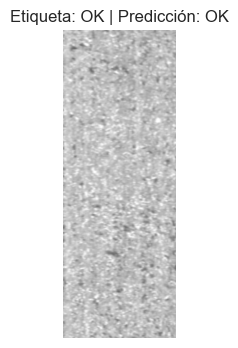

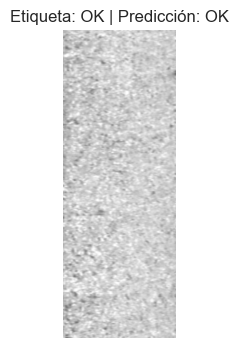

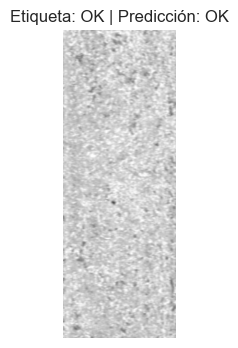

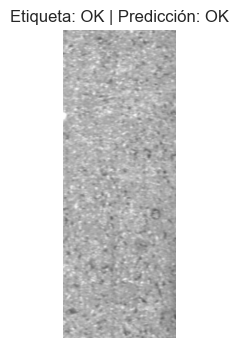

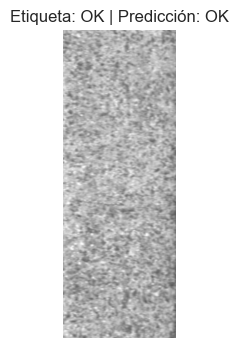

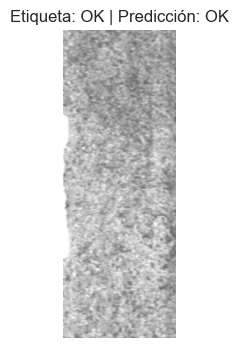

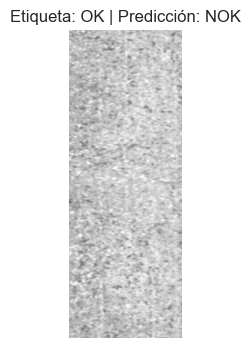

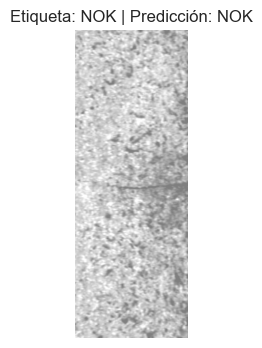

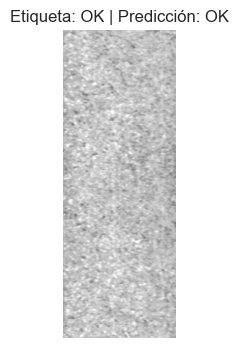

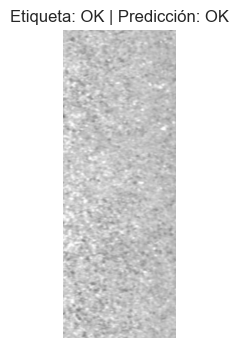

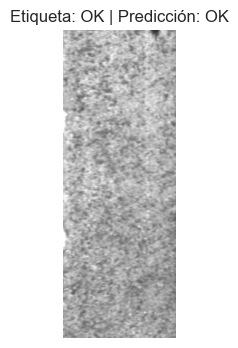

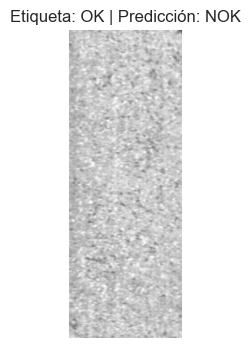

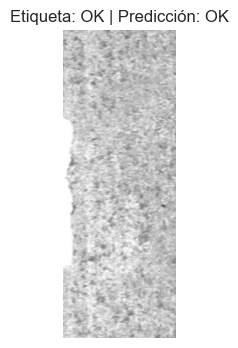

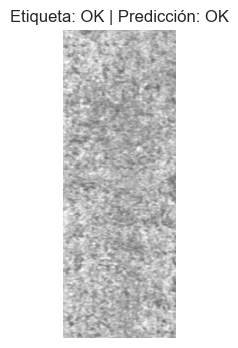

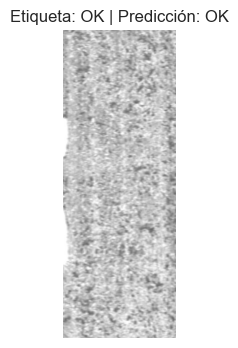

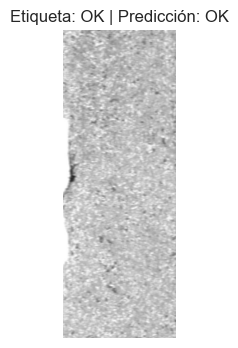

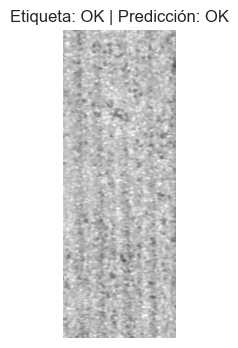

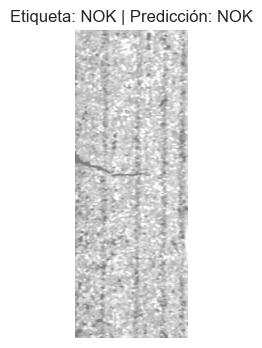

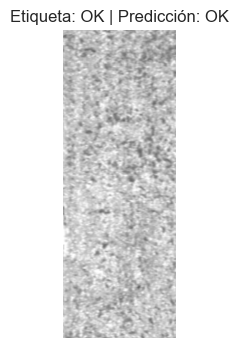

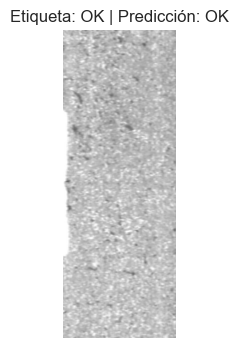

In [34]:
# Mostrar 10 imágenes del conjunto de prueba con etiquetas y predicciones
show_predictions(model, test_loader, num_images=20)

In [35]:
import pickle

# save
with open('model_resnet_sin_aumentar.pkl','wb') as f:
    pickle.dump(model,f)